In [ ]:
#CODE-
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score, davies_bouldin_score
import matplotlib.pyplot as plt

In [3]:
# Load the dataset
file_path = '/Users/hibaali/Desktop/Coding.html/python/ObesityDataSet_raw_and_data_sinthetic.csv'
data = pd.read_csv(file_path)

# Encode categorical variables
categorical_cols = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 
                    'SMOKE', 'SCC', 'CALC', 'MTRANS']
data = pd.get_dummies(data, columns=categorical_cols)

# Separate features and target
X = data.drop(columns=['NObeyesdad'])
y = LabelEncoder().fit_transform(data['NObeyesdad'])

In [4]:
# Define different scalers to experiment with
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

# Parameters for DBSCAN
eps_range = np.arange(0.1, 2.0, 0.1)
min_samples_range = range(2, 10)

best_silhouette_score = -1
best_ari_score = -1
best_db_score = float('inf')
best_params = {}
best_labels = None
best_scaler_name = ''
best_pca = None

In [5]:
for scaler_name, scaler in scalers.items():
    # Scale the data
    X_scaled = scaler.fit_transform(X)

    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    for eps in eps_range:
        for min_samples in min_samples_range:
            # Fit DBSCAN
            db = DBSCAN(eps=eps, min_samples=min_samples)
            labels = db.fit_predict(X_scaled)

            # Calculate silhouette score only if more than one cluster is found
            if len(set(labels)) > 1:
                sil_score = silhouette_score(X_scaled, labels)
                ari_score = adjusted_rand_score(y, labels)
                db_score = davies_bouldin_score(X_scaled, labels)

                if sil_score > best_silhouette_score:
                    best_silhouette_score = sil_score
                    best_ari_score = ari_score
                    best_db_score = db_score
                    best_params = {'eps': eps, 'min_samples': min_samples}
                    best_labels = labels
                    best_scaler_name = scaler_name
                    best_pca = X_pca

Best Scaler: MinMaxScaler
Best Parameters: eps=1.4000000000000001, min_samples=2
Best Silhouette Score: 0.4519
Best Adjusted Rand Index (ARI): 0.2635
Best Davies-Bouldin Score: 1.3594


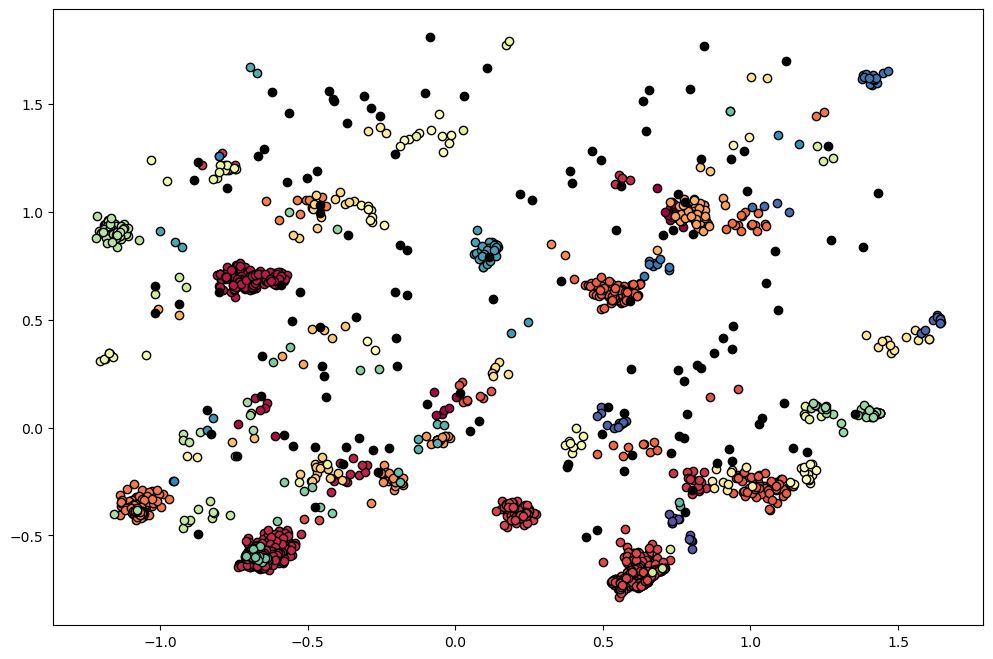

In [6]:
# Print the best parameters and scores
print(f"Best Scaler: {best_scaler_name}")
print(f"Best Parameters: eps={best_params['eps']}, min_samples={best_params['min_samples']}")
print(f"Best Silhouette Score: {best_silhouette_score:.4f}")
print(f"Best Adjusted Rand Index (ARI): {best_ari_score:.4f}")
print(f"Best Davies-Bouldin Score: {best_db_score:.4f}")

# Plot the best clustering result
plt.figure(figsize=(12, 8))
unique_labels = set(best_labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]  # Black color for noise

    class_member_mask = (best_labels == k)
    xy = best_pca[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6, label=f'Cluster {k}')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


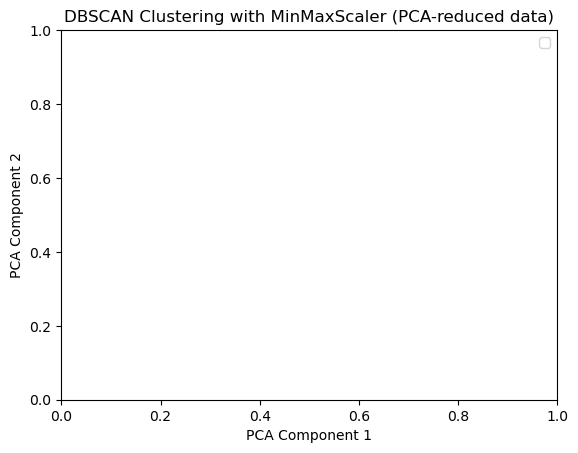

In [7]:
plt.title(f'DBSCAN Clustering with {best_scaler_name} (PCA-reduced data)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()